In [219]:
import numpy as np
import matplotlib.pyplot as plt

In [220]:
from loaders import clean_text_for_pattern_letter
from temp_text import template_str
input_str = clean_text_for_pattern_letter(template_str, out_len=500)
print(len(input_str))
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
               'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', '\'', '1']
print(f'{letters=}')

len(letters)=32
500
letters=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', "'", '1']


In [221]:
def predict_train(input_str, letters, max_index:int = 4,):
    next_index: dict[str, int] = {}
    index_by_prev: dict[str, dict] = {}

    StatsDict: dict[str, dict] = {}

    for letter in letters:
        next_index[letter] = 1

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_idx = inp_idx - 1
        prev_inp = input_str[prev_idx]
        
        inp_index = next_index[inp]

        prev_index = next_index[prev_inp]

        stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
        StatsDict.setdefault(stats_key, {})

        next_inp = input_str[inp_idx + 1]
        StatsDict[stats_key].setdefault(next_inp, 0)

        StatsDict[stats_key][next_inp] += 1

        by_prev_key = prev_inp + str(prev_index) + ':' + inp
        index_by_prev.setdefault(by_prev_key, {})
        index_by_prev[by_prev_key].setdefault(inp_index, 0)
        index_by_prev[by_prev_key][inp_index] += 1

        by_prev_key = prev_inp + str(0) + ':' + inp
        index_by_prev.setdefault(by_prev_key, {})
        index_by_prev[by_prev_key].setdefault(inp_index, 0)
        index_by_prev[by_prev_key][inp_index] += 1
        
        next_index[prev_inp] += 1
        if next_index[prev_inp] > max_index:
            next_index[prev_inp] = 1
    
    return StatsDict, index_by_prev

In [222]:
def predict(input_str, TF:list, StatsDict:dict, index_by_prev:dict, max_index, err = 0,):
    prev_index_l = [x for x in range(1, max_index+1)]

    output = []

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_inp = input_str[inp_idx - 1]
        
        index_l = []
        stats_d = {}
        index_d = {}
        for prev_index in prev_index_l:
            by_prev_key = prev_inp + str(prev_index) + ':' + inp
            # print(by_prev_key)
            inp_index_arr = index_by_prev.get(by_prev_key, {-1: -1})
            # print(inp_index_arr)

            for inp_index, val in inp_index_arr.items():
                if inp_index != -1:
                    index_d.setdefault(inp_index, 0)
                    index_d[inp_index] += val

                if inp_index != -1 and index_l.__contains__(inp_index) == False:
                    index_l.append(inp_index)

                    stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
                    stats = StatsDict.get(stats_key, {})

                    next_inp = input_str[inp_idx + 1]
                    # print(next_inp, stats_key, stats)
                    for st_key, st in stats.items():
                        stats_d.setdefault(st_key, 0)
                        stats_d[st_key] += 1

        max_key_d = max(index_d, key=index_d.get)
        if inp == prev_inp:
            pred_max_key = max_key_d
            max_key_d += 1
            if max_key_d > max_index:
                max_key_d = 1
            
            index_d[max_key_d] = index_d[pred_max_key]
            index_d.pop(pred_max_key)

        if len(stats_d) > 0:
            max_key = max(stats_d, key=stats_d.get)
            print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)
            # B B {'B': 1} [3] {3: 1} [3] False
            output.append(max_key)

        prev_index_l = list(index_d.keys())
        
        if max_key != next_inp:
            err += 1

        tf = len(index_l)
        TF.append(tf)
    
    output.insert(0, input_str[1])
    
    return TF, err, output

In [223]:
# train
max_index_L1 = 4

index_by_prev_L1: dict[str, dict] = {}
StatsDict_L1: dict[str, dict] = {}

StatsDict, index_by_prev_L1 = predict_train(letters=letters, input_str=input_str, max_index=max_index_L1)

In [224]:
for sdk, sdv in index_by_prev_L1.items():
    print(sdk, sdv)
    print('')

t1:h {1: 2}

t0:h {1: 4, 2: 2, 3: 3, 4: 2}

h1:e {1: 1, 4: 3}

h0:e {1: 1, 3: 3, 4: 5, 2: 4}

e1:  {1: 2, 4: 1}

e0:  {1: 6, 3: 4, 4: 4, 2: 3}

 1:s {1: 1}

 0:s {1: 1, 3: 2, 4: 1, 2: 2}

s1:k {1: 1}

s0:k {1: 1}

k1:y {1: 1}

k0:y {1: 1}

y1:  {2: 1}

y0:  {2: 1, 1: 2, 3: 1}

 2:a {1: 1}

 0:a {1: 3, 3: 5, 2: 2, 4: 2}

a1:b {1: 1}

a0:b {1: 1}

b1:o {1: 1}

b0:o {1: 1, 2: 2}

o1:v {1: 1}

o0:v {1: 1}

v1:e {2: 1}

v0:e {2: 1, 3: 2, 1: 1}

e2:  {3: 3, 2: 1, 1: 2}

 3:t {2: 2, 3: 1, 4: 1}

 0:t {2: 5, 4: 3, 1: 3, 3: 3}

t2:h {2: 2, 1: 2, 4: 1}

h2:e {3: 2, 2: 2}

e3:  {4: 2, 1: 1, 2: 2}

 4:p {1: 1}

 0:p {1: 2, 4: 1}

p1:o {2: 1}

p0:o {2: 1}

o2:r {1: 2}

o0:r {1: 3, 2: 2, 4: 1}

r1:t {3: 1}

r0:t {3: 1}

t3:  {1: 1}

t0:  {1: 2, 4: 1}

 1:w {1: 1}

 0:w {1: 1, 2: 2, 4: 2, 3: 2}

w1:a {2: 1}

w0:a {2: 3, 1: 2}

a2:s {2: 2, 1: 1}

a0:s {2: 2, 1: 3, 3: 3}

s2:  {2: 1, 4: 1}

s0:  {2: 2, 4: 7, 1: 2, 3: 3}

 2:t {4: 1, 2: 1, 3: 2}

t4:h {3: 2, 4: 1}

h3:e {4: 2, 2: 1}

e4:  {3: 1, 1: 1, 4

In [225]:
for sdk, sdv in StatsDict.items():
    print(sdk, sdv)
    print('')

t1:h1 {'e': 2}

h1:e1 {' ': 1}

e1: 1 {'s': 1, 'd': 1}

 1:s1 {'k': 1}

s1:k1 {'y': 1}

k1:y1 {' ': 1}

y1: 2 {'a': 1}

 2:a1 {'b': 1}

a1:b1 {'o': 1}

b1:o1 {'v': 1}

o1:v1 {'e': 1}

v1:e2 {' ': 1}

e2: 3 {'t': 1, 's': 1, 'c': 1}

 3:t2 {'h': 2}

t2:h2 {'e': 2}

h2:e3 {' ': 2}

e3: 4 {'p': 1, 'f': 1}

 4:p1 {'o': 1}

p1:o2 {'r': 1}

o2:r1 {'t': 1, 'd': 1}

r1:t3 {' ': 1}

t3: 1 {'w': 1}

 1:w1 {'a': 1}

w1:a2 {'s': 1}

a2:s2 {' ': 1, 'e': 1}

s2: 2 {'t': 1}

 2:t4 {'h': 1}

t4:h3 {'e': 1, 'i': 1}

h3:e4 {' ': 1, 'a': 1}

e4: 3 {'c': 1}

 3:c1 {'o': 1}

c1:o3 {'l': 1}

o3:l1 {'o': 1}

l1:o4 {'r': 1}

o4:r2 {' ': 2}

r2: 4 {'o': 1}

 4:o1 {'f': 1}

o1:f1 {' ': 1}

f1: 1 {'t': 1}

 1:t1 {'e': 1}

t1:e1 {'l': 1, 's': 1}

e1:l2 {'e': 1}

l2:e2 {'v': 1}

e2:v2 {'i': 1, 'e': 1}

v2:i1 {'s': 1}

i1:s3 {'i': 1}

s3:i2 {'o': 1}

i2:o2 {'n': 1}

o2:n1 {',': 1, 'o': 1}

n1:,1 {' ': 1}

,1: 2 {'t': 1}

 2:t2 {'u': 1}

t2:u1 {'n': 1}

u1:n2 {'e': 1}

n2:e3 {'d': 1}

e3:d1 {' ': 1}

d1: 3 {'t': 1}



In [226]:
# predict
TF = []

TF, err, out_L1 = predict(input_str=input_str, TF=TF, StatsDict=StatsDict, index_by_prev=index_by_prev_L1, max_index=max_index_L1)

print(err, err / (len(input_str) / 100) )

e e {'e': 4} [1, 2, 4, 3] {1: 4, 2: 2, 4: 2, 3: 3} [1, 2, 3, 4] False
    {' ': 4, 'a': 1, 't': 1, 'r': 1} [1, 4, 3, 2] {1: 1, 4: 5, 3: 3, 2: 4} [1, 2, 4, 3] False
s s {'s': 2, 'd': 2, 'm': 1, 'c': 1} [1, 4, 3, 2] {1: 6, 4: 4, 3: 4, 2: 3} [1, 4, 3, 2] False
p k {'k': 1, 'a': 1, 'o': 1, 'p': 2, 'h': 1} [1, 4, 3, 2] {1: 1, 4: 1, 3: 2, 2: 2} [1, 4, 3, 2] False
y y {'y': 1} [1] {1: 1} [1, 4, 3, 2] False
    {' ': 1} [1] {1: 1} [1] False
a a {'a': 1} [2] {2: 1} [1] False
b b {'b': 1} [1] {1: 1} [2] False
o o {'o': 1} [1] {1: 1} [1] False
v v {'v': 1} [1] {1: 1} [1] False
e e {'e': 1} [1] {1: 1} [1] False
    {' ': 1} [2] {2: 1} [1] False
c t {'t': 1, 's': 1, 'c': 2, 'i': 1, 'f': 1} [3, 2, 1] {3: 3, 2: 1, 1: 2} [2] False
h h {'h': 2, 'o': 1, 'e': 1} [2, 3, 4, 1] {2: 4, 3: 3, 4: 3, 1: 1} [3, 2, 1] False
e e {'e': 4, 'r': 1} [2, 1, 4, 3] {2: 2, 1: 4, 4: 2, 3: 3} [2, 3, 4, 1] False
    {' ': 4, 'r': 1, 'a': 1, 't': 1} [3, 2, 1, 4] {3: 3, 2: 4, 1: 1, 4: 5} [2, 1, 4, 3] False
s p {'p': 1, 'f': 1,

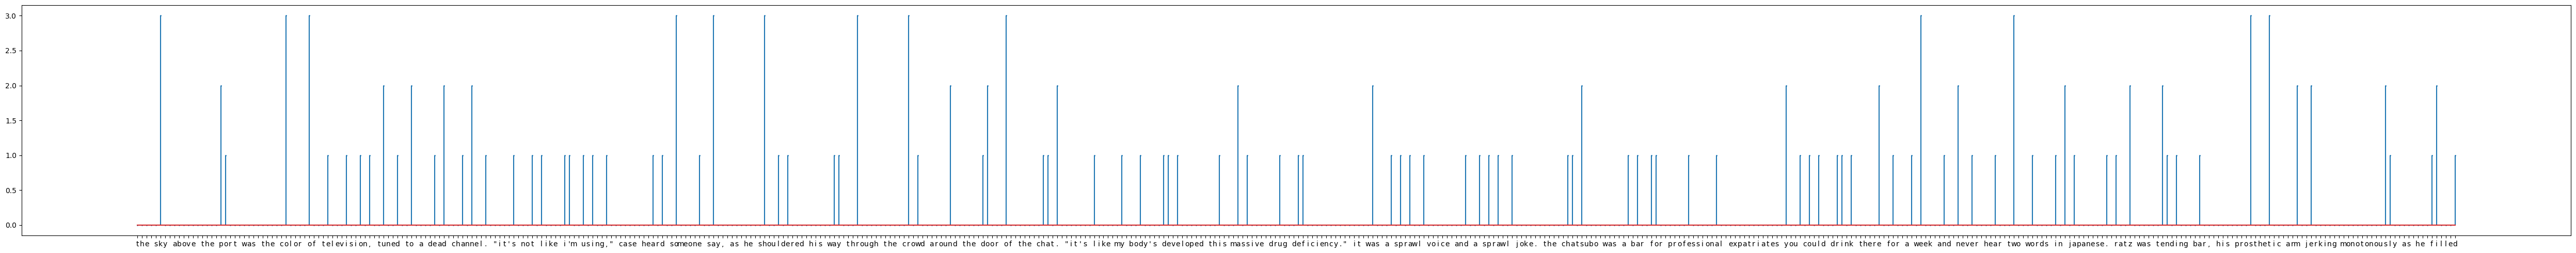

In [227]:
TF = np.array(TF, dtype=float)
# print(TF)
TF = np.pad(TF, (1, 1), constant_values=[1,1])
# print(TF)
TF = np.pad(TF, (1, 0))[:-1] - TF
# TF = TF - np.pad(TF, (1, 0))[:-1] 
# TF = np.pad(TF, (1, 0))[:-1] - TF
# TF = TF - np.pad(TF, (0, 1))[-1:]
# print(TF)
TF[np.where(TF < 0)] = 0
# TF = np.abs(TF)
# TF[np.where(TF <= np.mean(TF[np.where(TF > 0)]))] = 0
# # TF[np.where(TF <= 0.5)] = 0
# print(TF.size, TF.max(), TF.min())

fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
# axs.plot(np.arange(TF.size), TF)
markerline, stemline, baseline, = axs.stem(np.arange(TF.size), TF)
plt.setp(markerline, markersize = 1)
axs.xaxis.set_ticks(np.arange(len(input_str)) ,input_str)
# axs.xaxis.grid(True)

plt.show()

In [228]:
upstream_inp: dict[int, list] = {}

temp_seq = []

for inp_idx, inp in enumerate(input_str):
    tf = TF[inp_idx]
    
    if tf > 0:
        upstream_inp.setdefault(inp_idx, temp_seq.copy())
        temp_seq.clear()

    temp_seq.append(inp)

for item, val in upstream_inp.items():
    print(item, val)
    
print(len(upstream_inp))

5 ['t', 'h', 'e', ' ', 's']
18 ['k', 'y', ' ', 'a', 'b', 'o', 'v', 'e', ' ', 't', 'h', 'e', ' ']
19 ['p']
32 ['o', 'r', 't', ' ', 'w', 'a', 's', ' ', 't', 'h', 'e', ' ', 'c']
37 ['o', 'l', 'o', 'r', ' ']
41 ['o', 'f', ' ', 't']
45 ['e', 'l', 'e', 'v']
48 ['i', 's', 'i']
50 ['o', 'n']
53 [',', ' ', 't']
56 ['u', 'n', 'e']
59 ['d', ' ', 't']
64 ['o', ' ', 'a', ' ', 'd']
66 ['e', 'a']
70 ['d', ' ', 'c', 'h']
72 ['a', 'n']
75 ['n', 'e', 'l']
81 ['.', ' ', '"', 'i', 't', "'"]
85 ['s', ' ', 'n', 'o']
87 ['t', ' ']
92 ['l', 'i', 'k', 'e', ' ']
93 ['i']
96 ["'", 'm', ' ']
98 ['u', 's']
101 ['i', 'n', 'g']
111 [',', '"', ' ', 'c', 'a', 's', 'e', ' ', 'h', 'e']
113 ['a', 'r']
116 ['d', ' ', 's']
121 ['o', 'm', 'e', 'o', 'n']
124 ['e', ' ', 's']
135 ['a', 'y', ',', ' ', 'a', 's', ' ', 'h', 'e', ' ', 's']
138 ['h', 'o', 'u']
140 ['l', 'd']
150 ['e', 'r', 'e', 'd', ' ', 'h', 'i', 's', ' ', 'w']
151 ['a']
155 ['y', ' ', 't', 'h']
166 ['r', 'o', 'u', 'g', 'h', ' ', 't', 'h', 'e', ' ', 'c']
168 ['r', 

In [229]:
letters_dict: dict[str, int] = {}
for let_idx, letter in enumerate(letters):
    letters_dict.setdefault(letter, let_idx)

upstream_patterns = []

for upstream_letters in upstream_inp.values():
    upstream_pattern = np.zeros(len(letters))

    for letter in upstream_letters:
        pattern_idx = letters_dict.get(letter, 0)

        upstream_pattern[pattern_idx] = 1
    
    upstream_patterns.append(upstream_pattern)

upstream_patterns = np.array(upstream_patterns)

for up_ptr in upstream_patterns:
    print(up_ptr.astype(int).tolist())

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [230]:
layer_size = 24

I = np.zeros(upstream_patterns.shape[1])
O = np.zeros(layer_size)
W = np.ones((O.size, I.size))
Trace = np.zeros((O.size, I.size))
print('W', W.shape, W.max(), W.min(), np.median(W))

k = 1
push_delta = 0.4

prec = 1e-30

epoch_cnt = 100
eps0 = 0.02

eps = 0.05
rate_drop = 0.0

AVG_O = np.zeros(O.shape)
AVG_O_CNT = np.zeros(O.shape)

samples_idx = np.arange(upstream_patterns.shape[0])

for epoch_idx in range(epoch_cnt):
    np.random.shuffle(samples_idx)

    for i_idx in samples_idx:
        I = upstream_patterns[i_idx]

        # infer
        O = np.dot(W, I)

        # train
        winner_ids = np.argsort(O)[::-1][:1+k]
        winner = winner_ids[0]
        loosers = winner_ids[1:1+k]

        # update
        W[winner] = (1 - eps) * W[winner] + eps * (I - 0.5) + Trace[winner]*eps
        W[winner] = np.clip(W[winner], -1, 1)

        # W[loosers] = (1 - eps) * W[loosers] + (eps * (I - 0.5) * -push_delta) + Trace[loosers]*eps
        # W[loosers] = np.clip(W[loosers], -1, 1)

        # update Trace
        rate_Trace = np.zeros(I.shape)
        rate_Trace[(I > 0.5)] = 0.3
        rate_Trace[(I < 0.5)] = -0.001

        dTrace = np.zeros(W.shape)
        dTrace[winner] = rate_Trace
        Trace += dTrace
        Trace = np.clip(Trace, 0, 1)

        eps -= eps * rate_drop

print('W', W.shape, W.max(), W.min(), np.median(W))

W (24, 32) 1.0 1.0 1.0
W (24, 32) 1.0 -0.4999999999999995 -0.4999992163034218


In [231]:
SL_symbols = [x.capitalize() for x in letters][:layer_size]
print(len(SL_symbols))

SLSymbolDict = {}

SL_symbols_d = {}
for idx, val in enumerate(SL_symbols):
    SL_symbols_d.setdefault(val + ':' + str(idx), 0)

upstream_inp_keys = list(upstream_inp.keys())

upstream_cluster_by_symbol: dict[str, int] = {}
for idx, val in enumerate(SL_symbols):
    upstream_cluster_by_symbol.setdefault(val, idx)

for upstr_idx, up_ptr in enumerate(upstream_patterns):
    O = np.dot(W, up_ptr)

    winner = np.argmax(O)
    symbol = SL_symbols[winner]
    print(SL_symbols[winner])

    # print(W[upstream_cluster_by_symbol[symbol]].tolist())

    sls = SL_symbols[winner]
    sls_key = upstream_inp_keys[upstr_idx]
    SLSymbolDict.setdefault(sls_key, sls)
    
    SL_symbols_d[SL_symbols[winner] + ':' + str(winner)] += 1

print(len(SL_symbols_d))
for key, val in SL_symbols_d.items():
    print(key, val)

print(SLSymbolDict)

24
C
X
G
R
S
R
V
T
H
L
M
C
D
J
R
J
M
O
H
L
O
B
O
W
B
N
I
K
H
N
N
W
E
K
I
X
R
S
D
C
D
S
R
C
I
O
O
X
U
D
V
R
T
N
K
D
A
O
N
N
G
Q
H
D
N
G
Q
R
C
I
Q
X
I
P
S
H
T
W
R
W
E
I
B
R
R
D
Q
A
U
M
R
I
D
K
B
F
J
O
I
Q
A
U
X
N
C
I
F
I
N
N
P
O
24
A:0 3
B:1 4
C:2 6
D:3 8
E:4 2
F:5 2
G:6 3
H:7 5
I:8 10
J:9 3
K:10 4
L:11 2
M:12 3
N:13 10
O:14 8
P:15 2
Q:16 5
R:17 11
S:18 4
T:19 3
U:20 3
V:21 2
W:22 4
X:23 5
{5: 'C', 18: 'X', 19: 'G', 32: 'R', 37: 'S', 41: 'R', 45: 'V', 48: 'T', 50: 'H', 53: 'L', 56: 'M', 59: 'C', 64: 'D', 66: 'J', 70: 'R', 72: 'J', 75: 'M', 81: 'O', 85: 'H', 87: 'L', 92: 'O', 93: 'B', 96: 'O', 98: 'W', 101: 'B', 111: 'N', 113: 'I', 116: 'K', 121: 'H', 124: 'N', 135: 'N', 138: 'W', 140: 'E', 150: 'K', 151: 'I', 155: 'X', 166: 'R', 168: 'S', 175: 'D', 182: 'C', 183: 'D', 187: 'S', 195: 'R', 196: 'C', 198: 'I', 206: 'O', 212: 'O', 216: 'X', 221: 'U', 222: 'D', 224: 'V', 233: 'R', 237: 'T', 239: 'N', 246: 'K', 250: 'D', 251: 'A', 266: 'O', 270: 'N', 272: 'N', 274: 'G', 277: 'Q', 286: 'H', 289

In [232]:
sl_input = list(SLSymbolDict.values())
print(sl_input)

['C', 'X', 'G', 'R', 'S', 'R', 'V', 'T', 'H', 'L', 'M', 'C', 'D', 'J', 'R', 'J', 'M', 'O', 'H', 'L', 'O', 'B', 'O', 'W', 'B', 'N', 'I', 'K', 'H', 'N', 'N', 'W', 'E', 'K', 'I', 'X', 'R', 'S', 'D', 'C', 'D', 'S', 'R', 'C', 'I', 'O', 'O', 'X', 'U', 'D', 'V', 'R', 'T', 'N', 'K', 'D', 'A', 'O', 'N', 'N', 'G', 'Q', 'H', 'D', 'N', 'G', 'Q', 'R', 'C', 'I', 'Q', 'X', 'I', 'P', 'S', 'H', 'T', 'W', 'R', 'W', 'E', 'I', 'B', 'R', 'R', 'D', 'Q', 'A', 'U', 'M', 'R', 'I', 'D', 'K', 'B', 'F', 'J', 'O', 'I', 'Q', 'A', 'U', 'X', 'N', 'C', 'I', 'F', 'I', 'N', 'N', 'P', 'O']


In [233]:
# SL train
max_index_L2 = 4

StatsDict_L2, index_by_prev_L2 = predict_train(input_str=sl_input, letters=SL_symbols, max_index=max_index_L2)

In [234]:
for sdk, sdv in StatsDict_L2.items():
    print(sdk, sdv)
    print('')

C1:X1 {'G': 1}

X1:G1 {'R': 1}

G1:R1 {'S': 1}

R1:S1 {'R': 1}

S1:R2 {'V': 1}

R2:V1 {'T': 1}

V1:T1 {'H': 1}

T1:H1 {'L': 1}

H1:L1 {'M': 1}

L1:M1 {'C': 1}

M1:C2 {'D': 1}

C2:D1 {'J': 1}

D1:J1 {'R': 1}

J1:R3 {'J': 1}

R3:J2 {'M': 1}

J2:M2 {'O': 1}

M2:O1 {'H': 1}

O1:H2 {'L': 1}

H2:L2 {'O': 1}

L2:O2 {'B': 1}

O2:B1 {'O': 1}

B1:O3 {'W': 1}

O3:W1 {'B': 1}

W1:B2 {'N': 1}

B2:N1 {'I': 1}

N1:I1 {'K': 1}

I1:K1 {'H': 1}

K1:H3 {'N': 1}

H3:N2 {'N': 1}

N2:N2 {'W': 1}

N3:W2 {'E': 1}

W2:E1 {'K': 1}

E1:K2 {'I': 1}

K2:I2 {'X': 1}

I2:X2 {'R': 1}

X2:R4 {'S': 1}

R4:S2 {'D': 1}

S2:D2 {'C': 1}

D2:C3 {'D': 1}

C3:D3 {'S': 1}

D3:S3 {'R': 1}

S3:R1 {'C': 1}

R1:C4 {'I': 1}

C4:I3 {'O': 1}

I3:O4 {'O': 1}

O4:O4 {'X': 1}

O1:X3 {'U': 1}

X3:U1 {'D': 1}

U1:D4 {'V': 1}

D4:V2 {'R': 1}

V2:R2 {'T': 1}

R2:T2 {'N': 1}

T2:N4 {'K': 1}

N4:K3 {'D': 1}

K3:D1 {'A': 1}

D1:A1 {'O': 1}

A1:O2 {'N': 1}

O2:N1 {'N': 1}

N1:N1 {'G': 1, 'P': 1}

N2:G2 {'Q': 1}

G2:Q1 {'H': 1}

Q1:H4 {'D': 1}



In [235]:
for sdk, sdv in index_by_prev_L2.items():
    print(sdk, sdv)
    print('')

C1:X {1: 1}

C0:X {1: 1}

X1:G {1: 1}

X0:G {1: 1}

G1:R {1: 1}

G0:R {1: 1}

R1:S {1: 1}

R0:S {1: 1, 2: 1}

S1:R {2: 1}

S0:R {2: 1, 1: 1}

R2:V {1: 1}

R0:V {1: 1}

V1:T {1: 1}

V0:T {1: 1}

T1:H {1: 1}

T0:H {1: 1}

H1:L {1: 1}

H0:L {1: 1, 2: 1}

L1:M {1: 1}

L0:M {1: 1}

M1:C {2: 1}

M0:C {2: 1}

C2:D {1: 1}

C0:D {1: 1, 3: 1}

D1:J {1: 1}

D0:J {1: 1}

J1:R {3: 1}

J0:R {3: 1}

R3:J {2: 1}

R0:J {2: 1}

J2:M {2: 1}

J0:M {2: 1}

M2:O {1: 1}

M0:O {1: 1}

O1:H {2: 1}

O0:H {2: 1}

H2:L {2: 1}

L2:O {2: 1}

L0:O {2: 1}

O2:B {1: 1}

O0:B {1: 1}

B1:O {3: 1}

B0:O {3: 1}

O3:W {1: 1}

O0:W {1: 1}

W1:B {2: 1}

W0:B {2: 1}

B2:N {1: 1}

B0:N {1: 1}

N1:I {1: 1}

N0:I {1: 1}

I1:K {1: 1}

I0:K {1: 1}

K1:H {3: 1}

K0:H {3: 1}

H3:N {2: 1}

H0:N {2: 1}

N2:N {2: 1}

N0:N {2: 1, 1: 2}

N3:W {2: 1}

N0:W {2: 1}

W2:E {1: 1}

W0:E {1: 1, 2: 1}

E1:K {2: 1}

E0:K {2: 1}

K2:I {2: 1}

K0:I {2: 1}

I2:X {2: 1}

I0:X {2: 1}

X2:R {4: 1}

X0:R {4: 1}

R4:S {2: 1}

S2:D {2: 1}

S0:D {2: 1}

D2

In [236]:
# predict
TF_L2 = []

TF_L2, err_L2, out_L2 = predict(input_str=sl_input, 
                                TF=TF_L2, 
                                StatsDict=StatsDict_L2, 
                                index_by_prev=index_by_prev_L2, 
                                max_index=max_index_L2)

for o in out_L2:
    print(o)

print(err_L2, err_L2 / (len(sl_input) / 100), len(sl_input), len(out_L2) )

G G {'G': 1} [1] {1: 1} [1, 2, 3, 4] False
R R {'R': 1} [1] {1: 1} [1] False
S S {'S': 1} [1] {1: 1} [1] False
R R {'R': 1} [1] {1: 1} [1] False
V V {'V': 1} [2] {2: 1} [1] False
T T {'T': 1} [1] {1: 1} [2] False
H H {'H': 1} [1] {1: 1} [1] False
L L {'L': 1} [1] {1: 1} [1] False
M M {'M': 1} [1] {1: 1} [1] False
C C {'C': 1} [1] {1: 1} [1] False
D D {'D': 1} [2] {2: 1} [1] False
J J {'J': 1} [1] {1: 1} [2] False
R R {'R': 1} [1] {1: 1} [1] False
J J {'J': 1} [3] {3: 1} [1] False
M M {'M': 1} [2] {2: 1} [3] False
O O {'O': 1} [2] {2: 1} [2] False
H H {'H': 1} [1] {1: 1} [2] False
L L {'L': 1} [2] {2: 1} [1] False
O O {'O': 1} [2] {2: 1} [2] False
B B {'B': 1} [2] {2: 1} [2] False
O O {'O': 1} [1] {1: 1} [2] False
W W {'W': 1} [3] {3: 1} [1] False
B B {'B': 1} [1] {1: 1} [3] False
N N {'N': 1} [2] {2: 1} [1] False
I I {'I': 1} [1] {1: 1} [2] False
K K {'K': 1} [1] {1: 1} [1] False
H H {'H': 1} [1] {1: 1} [1] False
N N {'N': 1} [3] {3: 1} [1] False
N N {'N': 1} [2] {2: 1} [3] False
W W {

In [237]:
# from itertools import cycle

def ds_predict(input_str, 
               StatsDict: dict, 
               index_by_prev: dict,
               upstream_cluster_by_symbol: dict,
               letters_dict: dict,
               out_L2: list,
               SLSymbolDict: dict,
               W,
               max_index):
    prev_index_l = [x for x in range(1, max_index+1)]

    err = 0
    TF = []
    output = []

    ds_out_idx = 0
    ds_inp = '0'
    ds_pattern = np.ones(W.shape[1])

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_inp = input_str[inp_idx - 1]
        
        index_l = []
        stats_d = {}
        index_d = {}
        for prev_index in prev_index_l:
            by_prev_key = prev_inp + str(prev_index) + ':' + inp
            # print(by_prev_key)
            inp_index_arr = index_by_prev.get(by_prev_key, {-1: -1})
            # print(inp_index_arr)

            for inp_index, val in inp_index_arr.items():
                if inp_index != -1:
                    index_d.setdefault(inp_index, 0)
                    index_d[inp_index] += val

                if inp_index != -1 and index_l.__contains__(inp_index) == False:
                    index_l.append(inp_index)

                    stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
                    stats = StatsDict.get(stats_key, {})

                    next_inp = input_str[inp_idx + 1]
                    # print(next_inp, stats_key, stats)
                    for st_key, st in stats.items():
                        stats_d.setdefault(st_key, 0)
                        stats_d[st_key] += 1

        # downstream pattern
        is_peak = SLSymbolDict.get(inp_idx, 0)
        if is_peak != 0:
            if ds_out_idx == len(out_L2):
                ds_inp = '0'
                ds_pattern = np.ones(W.shape[1])
            else:
                ds_inp = out_L2[ds_out_idx]
                ds_pattern = W[upstream_cluster_by_symbol.get(ds_inp)]
                # ds_pattern = np.copy(W[upstream_cluster_by_symbol.get(ds_inp)])
                # ds_pattern[np.where(ds_pattern < 0)] = 0

                ds_out_idx += 1
        print(stats_d)
        for st_key, st in stats_d.items():
            letter_idx = letters_dict.get(st_key)
            
            ds_stats = ds_pattern[letter_idx]
            print(st_key, ds_stats)
            if ds_stats <= 0:
                stats_d[st_key] = 0

                continue
            
            stats_d[st_key] *= ds_stats
        
        print(stats_d)
        print(input_str[inp_idx + 1])
        print()

        max_key_d = max(index_d, key=index_d.get)
        if inp == prev_inp:
            pred_max_key = max_key_d
            max_key_d += 1
            if max_key_d > max_index:
                max_key_d = 1
            
            index_d[max_key_d] = index_d[pred_max_key]
            index_d.pop(pred_max_key)

        if len(stats_d) > 0:
            max_key = max(stats_d, key=stats_d.get)
            # print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)
            output.append(max_key)

        prev_index_l = list(index_d.keys())
        
        if max_key != next_inp:
            err += 1

        tf = len(index_l)
        TF.append(tf)
    
    output.insert(0, input_str[1])
    
    return TF, err, output

In [238]:
dsp_TF, dsp_err, dsp_output = ds_predict(input_str=input_str,
                                         StatsDict=StatsDict,
                                         index_by_prev=index_by_prev_L1,
                                         upstream_cluster_by_symbol=upstream_cluster_by_symbol,
                                         letters_dict=letters_dict,
                                         out_L2=out_L2,
                                         SLSymbolDict=SLSymbolDict,
                                         W=W,
                                         max_index=max_index_L1)

print(dsp_err, dsp_err / (len(input_str) / 100))


{'e': 4}
e 1.0
{'e': 4.0}
e

{' ': 4, 'a': 1, 't': 1, 'r': 1}
  1.0
a 1.0
t 1.0
r 1.0
{' ': 4.0, 'a': 1.0, 't': 1.0, 'r': 1.0}
 

{'s': 2, 'd': 2, 'm': 1, 'c': 1}
s 1.0
d 1.0
m 1.0
c 1.0
{'s': 2.0, 'd': 2.0, 'm': 1.0, 'c': 1.0}
s

{'k': 1, 'a': 1, 'o': 1, 'p': 2, 'h': 1}
k 1.0
a 1.0
o 1.0
p 1.0
h 1.0
{'k': 1.0, 'a': 1.0, 'o': 1.0, 'p': 2.0, 'h': 1.0}
k

{'y': 1}
y 0.989241152125
{'y': 0.989241152125}
y

{' ': 1}
  1.0
{' ': 1.0}
 

{'a': 1}
a 0.7008508092409835
{'a': 0.7008508092409835}
a

{'b': 1}
b 1.0
{'b': 1.0}
b

{'o': 1}
o 0.9005704177532448
{'o': 0.9005704177532448}
o

{'v': 1}
v 0.7008508092409835
{'v': 0.7008508092409835}
v

{'e': 1}
e 0.7008508092409835
{'e': 0.7008508092409835}
e

{' ': 1}
  1.0
{' ': 1.0}
 

{'t': 1, 's': 1, 'c': 2, 'i': 1, 'f': 1}
t 0.9001594006144436
s -0.49999999997762495
c -0.49999999997762495
i 0.696455356940249
f -0.49999999997762495
{'t': 0.9001594006144436, 's': 0, 'c': 0, 'i': 0.696455356940249, 'f': 0}
t

{'h': 2, 'o': 1, 'e': 1}
h 0.9001594006144

In [239]:
def downstream_predict_train(input_str: str | list,
                             sl_input: list,
                             SLSymbolDict: dict,
                            #  ds_out: list,
                             StatsDict_L1: dict,
                            #  StatsDict_L2,
                            #  TF_L1,
                             index_by_prev_L1: dict,
                            #  index_by_prev_L2,
                             max_index_L1: int,
                            #  max_index_L2,
                             ):
    next_index: dict[str, int] = {}

    for letter in letters:
        next_index[letter] = 1

    ds_inp = '0'
    sl_inp_idx = 1

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_idx = inp_idx - 1
        prev_inp = input_str[prev_idx]

        inp_index = next_index[inp]

        prev_index = next_index[prev_inp]

        is_peak = SLSymbolDict.get(inp_idx, 0)
        if is_peak != 0:
            if sl_inp_idx == len(sl_input):
                ds_inp = '0'
            else:
                ds_inp = sl_input[sl_inp_idx]
                sl_inp_idx += 1
        # print(f'{ds_inp=}')
        stats_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp + str(inp_index)
        StatsDict_L1.setdefault(stats_key, {})

        next_inp = input_str[inp_idx + 1]
        StatsDict_L1[stats_key].setdefault(next_inp, 0)

        StatsDict_L1[stats_key][next_inp] += 1

        by_prev_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp
        index_by_prev_L1.setdefault(by_prev_key, {})
        index_by_prev_L1[by_prev_key].setdefault(inp_index, 0)
        index_by_prev_L1[by_prev_key][inp_index] += 1

        by_prev_key = ds_inp + ':' + prev_inp + str(0) + ':' + inp
        index_by_prev_L1.setdefault(by_prev_key, {})
        index_by_prev_L1[by_prev_key].setdefault(inp_index, 0)
        index_by_prev_L1[by_prev_key][inp_index] += 1

        next_index[prev_inp] += 1
        if next_index[prev_inp] > max_index_L1:
            next_index[prev_inp] = 1
        
    return StatsDict_L1, index_by_prev_L1


In [240]:
StatsDict_L1_ds = {}
index_by_prev_L1_ds = {}

StatsDict_L1_ds, index_by_prev_L1_ds = downstream_predict_train(input_str=input_str,
                                                                sl_input=sl_input,
                                                                SLSymbolDict=SLSymbolDict,
                                                                StatsDict_L1=StatsDict_L1_ds,
                                                                index_by_prev_L1=index_by_prev_L1_ds,
                                                                max_index_L1=max_index_L1, )

for key, val in StatsDict_L1_ds.items():
    print(key, val)

0:t1:h1 {'e': 1}
0:h1:e1 {' ': 1}
0:e1: 1 {'s': 1}
0: 1:s1 {'k': 1}
X:s1:k1 {'y': 1}
X:k1:y1 {' ': 1}
X:y1: 2 {'a': 1}
X: 2:a1 {'b': 1}
X:a1:b1 {'o': 1}
X:b1:o1 {'v': 1}
X:o1:v1 {'e': 1}
X:v1:e2 {' ': 1}
X:e2: 3 {'t': 1}
X: 3:t2 {'h': 1}
X:t2:h2 {'e': 1}
X:h2:e3 {' ': 1}
X:e3: 4 {'p': 1}
G: 4:p1 {'o': 1}
R:p1:o2 {'r': 1}
R:o2:r1 {'t': 1}
R:r1:t3 {' ': 1}
R:t3: 1 {'w': 1}
R: 1:w1 {'a': 1}
R:w1:a2 {'s': 1}
R:a2:s2 {' ': 1}
R:s2: 2 {'t': 1}
R: 2:t4 {'h': 1}
R:t4:h3 {'e': 1, 'i': 1}
R:h3:e4 {' ': 1, 'a': 1}
R:e4: 3 {'c': 1}
R: 3:c1 {'o': 1}
S:c1:o3 {'l': 1}
S:o3:l1 {'o': 1}
S:l1:o4 {'r': 1}
S:o4:r2 {' ': 1}
S:r2: 4 {'o': 1}
R: 4:o1 {'f': 1}
R:o1:f1 {' ': 1}
R:f1: 1 {'t': 1}
R: 1:t1 {'e': 1}
V:t1:e1 {'l': 1}
V:e1:l2 {'e': 1}
V:l2:e2 {'v': 1}
V:e2:v2 {'i': 1}
T:v2:i1 {'s': 1}
T:i1:s3 {'i': 1}
T:s3:i2 {'o': 1}
H:i2:o2 {'n': 1}
H:o2:n1 {',': 1}
L:n1:,1 {' ': 1}
L:,1: 2 {'t': 1}
L: 2:t2 {'u': 1}
M:t2:u1 {'n': 1}
M:u1:n2 {'e': 1}
M:n2:e3 {'d': 1}
C:e3:d1 {' ': 1}
C:d1: 3 {'t': 1}
C: 3:t3 {'o': 1

In [241]:
from itertools import cycle

print(out_L2)
def downstream_predict(input_str: str | list,
                       SLSymbolDict: dict,
                       StatsDict_L1_ds: dict,
                       index_by_prev_L1_ds: dict,
                       out_L2: list,
                       max_index_L1: int,
                       TF: list,
                       err=0,):
    prev_index_l = [x for x in range(1, max_index_L1+1)]

    ds_inp = '0'
    ds_out_idx = 0
    ds_predict_out = cycle(out_L2)

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_inp = input_str[inp_idx - 1]

        # print(inp, SLSymbolDict.get(inp_idx, 0))
        is_peak = SLSymbolDict.get(inp_idx, 0)
        if is_peak != 0:
            if ds_out_idx == len(out_L2):
                ds_inp = '0'
            else:
                ds_inp = out_L2[ds_out_idx]
                ds_out_idx += 1
        print(ds_inp, is_peak)
        index_l = []
        stats_d = {}
        index_d = {}
        for prev_index in prev_index_l:
            by_prev_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp
            # print(by_prev_key)
            inp_index_arr = index_by_prev_L1_ds.get(by_prev_key, {-1: -1})
            # print(inp_index_arr)

            for inp_index, val in inp_index_arr.items():
                if inp_index != -1:
                    index_d.setdefault(inp_index, 0)
                    index_d[inp_index] += val

                if inp_index != -1 and index_l.__contains__(inp_index) == False:
                    index_l.append(inp_index)

                    stats_key = ds_inp + ':' + prev_inp + \
                        str(prev_index) + ':' + inp + str(inp_index)
                    stats = StatsDict_L1_ds.get(stats_key, {})

                    next_inp = input_str[inp_idx + 1]
                    # print(next_inp, stats_key, stats)
                    for st_key, st in stats.items():
                        stats_d.setdefault(st_key, 0)
                        stats_d[st_key] += 1

        max_key_d = max(index_d, key=index_d.get)
        if inp == prev_inp:
            pred_max_key = max_key_d
            max_key_d += 1
            if max_key_d > max_index_L1:
                max_key_d = 1

            index_d[max_key_d] = index_d[pred_max_key]
            index_d.pop(pred_max_key)

        if len(stats_d) > 0:
            max_key = max(stats_d, key=stats_d.get)
            # print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)

        prev_index_l = list(index_d.keys())

        if max_key != next_inp:
            err += 1

        tf = len(index_l)
        TF.append(tf)

    return TF, err


['X', 'G', 'R', 'S', 'R', 'V', 'T', 'H', 'L', 'M', 'C', 'D', 'J', 'R', 'J', 'M', 'O', 'H', 'L', 'O', 'B', 'O', 'W', 'B', 'N', 'I', 'K', 'H', 'N', 'N', 'W', 'E', 'K', 'I', 'X', 'R', 'S', 'D', 'C', 'D', 'S', 'R', 'C', 'I', 'O', 'O', 'X', 'U', 'D', 'V', 'R', 'T', 'N', 'K', 'D', 'A', 'O', 'N', 'N', 'G', 'Q', 'H', 'D', 'N', 'G', 'Q', 'R', 'C', 'I', 'Q', 'X', 'I', 'P', 'S', 'H', 'T', 'W', 'R', 'W', 'E', 'I', 'B', 'R', 'R', 'D', 'Q', 'A', 'U', 'M', 'R', 'I', 'D', 'K', 'B', 'F', 'J', 'O', 'I', 'Q', 'X', 'U', 'X', 'N', 'C', 'I', 'F', 'I', 'N', 'N', 'G', 'O']


In [242]:
TF_L1_ds = []

TF_L1_ds, err_L1_ds = downstream_predict(input_str=input_str,
                                         SLSymbolDict=SLSymbolDict,
                                         StatsDict_L1_ds=StatsDict_L1_ds,
                                         index_by_prev_L1_ds=index_by_prev_L1_ds,
                                         out_L2=out_L2,
                                         max_index_L1=max_index_L1,
                                         TF=TF_L1_ds, )

print(err_L1_ds, err_L1_ds / (len(input_str) / 100))

0 0
0 0
0 0
0 0
X C
X 0
X 0
X 0
X 0
X 0
X 0
X 0
X 0
X 0
X 0
X 0
X 0
G X
R G
R 0
R 0
R 0
R 0
R 0
R 0
R 0
R 0
R 0
R 0
R 0
R 0
S R
S 0
S 0
S 0
S 0
R S
R 0
R 0
R 0
V R
V 0
V 0
V 0
T V
T 0
T 0
H T
H 0
L H
L 0
L 0
M L
M 0
M 0
C M
C 0
C 0
D C
D 0
D 0
D 0
D 0
J D
J 0
R J
R 0
R 0
R 0
J R
J 0
M J
M 0
M 0
O M
O 0
O 0
O 0
O 0
O 0
H O
H 0
H 0
H 0
L H
L 0
O L
O 0
O 0
O 0
O 0
B O
O B
O 0
O 0
W O
W 0
B W
B 0
B 0
N B
N 0
N 0
N 0
N 0
N 0
N 0
N 0
N 0
N 0
I N
I 0
K I
K 0
K 0
H K
H 0
H 0
H 0
H 0
N H
N 0
N 0
N N
N 0
N 0
N 0
N 0
N 0
N 0
N 0
N 0
N 0
N 0
W N
W 0
W 0
E W
E 0
K E
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
I K
X I
X 0
X 0
X 0
R X
R 0
R 0
R 0
R 0
R 0
R 0
R 0
R 0
R 0
R 0
S R
S 0
D S
D 0
D 0
D 0
D 0
D 0
D 0
C D
C 0
C 0
C 0
C 0
C 0
C 0
D C
S D
S 0
S 0
S 0
R S
R 0
R 0
R 0
R 0
R 0
R 0
R 0
C R
I C
I 0
O I
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O O
O 0
O 0
O 0
O 0
O 0
X O
X 0
X 0
X 0
U X
U 0
U 0
U 0
U 0
D U
V D
V 0
R V
R 0
R 0
R 0
R 0
R 0
R 0
R 0
R 0
T R
T 0
T 0
T 0
N T
N 0
K N
K 0
K 0
K 0
K 0
K 0
K 0
D K
D 0
D 0
D 0
A D


ValueError: max() arg is an empty sequence